# Using xhistogram to convert ocean model output from depth to density coordinates


In [1]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import gcsfs
from xhistogram.xarray import histogram

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [2]:
# The cluster was created using the dask jupyterlab extension
# Press "+new" to add a cluster and scale it to the size you want
from dask.distributed import Client

client = Client("tcp://10.32.2.13:40893")
client

Client Scheduler: tcp://10.32.2.13:40893 Dashboard: /user/0000-0003-1094-0306/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
def read_data(uri):
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [4]:
def vertical_rebin(data, bin_data, bins, dz, vert_dim="st_ocean"):
    nanmask = np.isnan(data)
    # Should we also check the bin data for nans?
    full_sum = histogram(
        bin_data.where(~nanmask),
        bins=[bins],
        weights=(data * dz).where(~nanmask),
        dim=[vert_dim],
    )
    return full_sum

def vertical_rebin_wrapper(
    ds,
    bin_data_name,
    bins,
    dz_name="dz",
    vert_dim="st_ocean",
    return_average=True,
    debug=False,
):
    """A wrapper for the core functionality in `vertical_rebin`.
    Accepts datasets and calculates the average over the new depth coordinates.
    """
    ds = ds.copy()
    ds_rebinned = xr.Dataset()
    
    ones = xr.ones_like(ds[dz_name])
    
    dz_rebinned = vertical_rebin(
        ones,
        ds[bin_data_name],
        bins,
        ds[dz_name],
        vert_dim=vert_dim,
    )
    for var in ds.data_vars:
        ds_rebinned[var] = vertical_rebin(
            ds[var], ds[bin_data_name], bins, ds[dz_name], vert_dim=vert_dim
        )
    if return_average:
        ds_rebinned = (
            ds_rebinned / dz_rebinned
        )  # this might cause a lot of overhead...i can try to deactivate if the save fails.

    ds_rebinned[dz_name] = dz_rebinned

    return ds_rebinned

In [12]:
# load the data (I searched for any model that had the required variables
# using @rabernats example:https://nbviewer.jupyter.org/gist/rabernat/2bbe3e4e675d841e86d7e5870692b663)

no3 = read_data('gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r10i1p1f1/Omon/no3/gn/')
thetao = read_data('gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r10i1p1f1/Omon/thetao/gn/')
so = read_data('gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r10i1p1f1/Omon/so/gn/')
dz = read_data('gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r10i1p1f1/Omon/thkcello/gn/')

#Here we calculate the approximate potential density 
#(note: Not all CMIP6 models use TEOS-10, so this potential density is only approximate)
import gsw
dens=xr.apply_ufunc(gsw.density.sigma0,so['so'], thetao['thetao'],dask='parallelized', output_dtypes=[float, ]
                   ).rename('dens').to_dataset()


In [13]:
ds = xr.merge([dens, no3, dz])
ds.coords['area'] = ds['area']
# look at just one year as example
ds = ds.isel(time=slice(0,12))

# carry the ocean depth as data_variable
ds['z'] = ds['olevel']

In [14]:
ds

<xarray.Dataset>
Dimensions:         (axis_nbounds: 2, nvertex: 4, olevel: 75, time: 12, x: 362, y: 332)
Coordinates:
    nav_lat         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    nav_lon         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * olevel          (olevel) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 1850-12-16T12:00:00
    area            (y, x, time) float32 dask.array<chunksize=(332, 362, 12), meta=np.ndarray>
    bounds_nav_lat  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    bounds_nav_lon  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    olevel_bounds   (olevel, axis_nbounds) float32 dask.array<chunksize=(75, 2), meta=np.ndarray>
    time_bounds     (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds, nvertex, x,

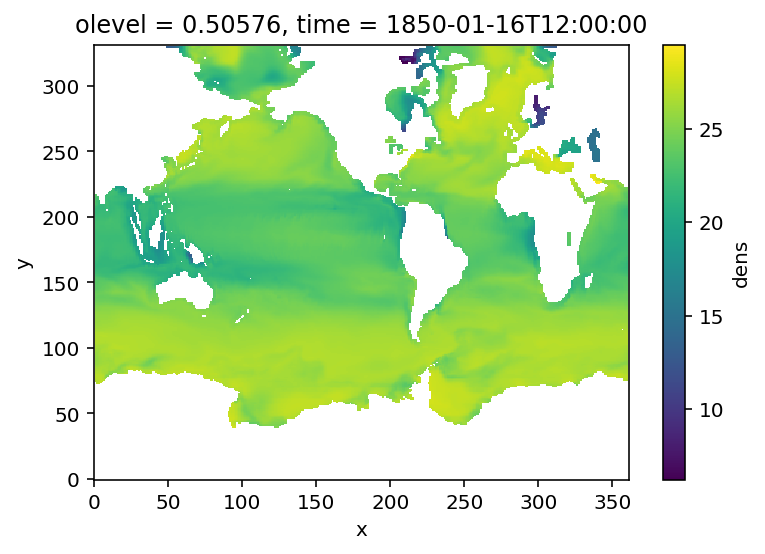

In [16]:
ds.dens.isel(olevel=0, time=0).plot()

In [41]:
#define bins (in units of potential density)
bins = np.arange(20, 28, 0.2)

In [42]:
ds_rebinned = vertical_rebin_wrapper(ds,
                                     'dens',
                                     bins,
                                     dz_name='thkcello',
                                     vert_dim='olevel')

<a list of 24 text.Text objects>

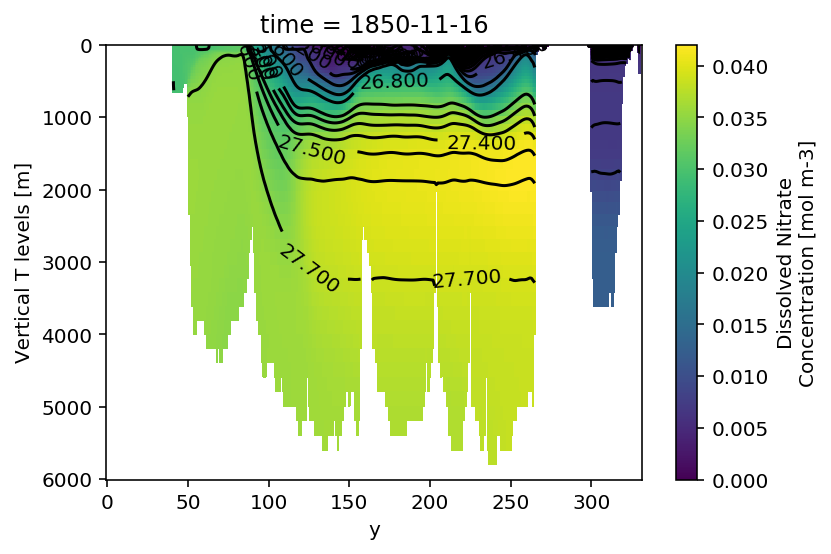

In [43]:
# define a slice along the central pacific and plot it agains depth
roi = dict(x=125, time=10)
ds.no3.isel(**roi).plot(yincrease=False)

#overlay contours of potential density
levels = np.concatenate([np.arange(20,27,0.2), np.arange(27.1, 28,0.1)])
ch = ds.dens.isel(**roi).plot.contour(
    colors='k',
    yincrease=False,
    levels=levels
)
plt.clabel(ch)

<a list of 6 text.Text objects>

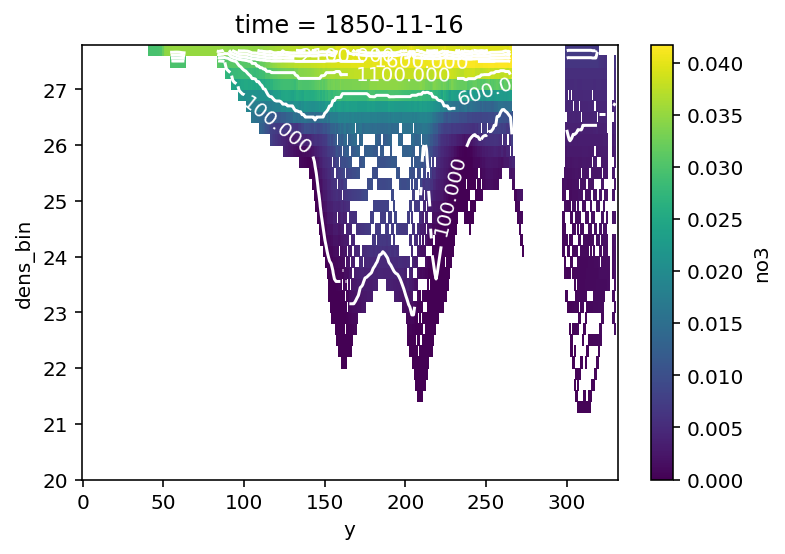

In [44]:
# plot the same slice in density coordinates
ds_rebinned.no3.isel(**roi).plot(x='y')

# we can now plot the depth of each isopycnal layer as contour
ch = ds_rebinned.z.isel(**roi).plot.contour(
    levels=np.arange(100,5000,500),
    colors='w',
    x='y'
)
plt.clabel(ch)

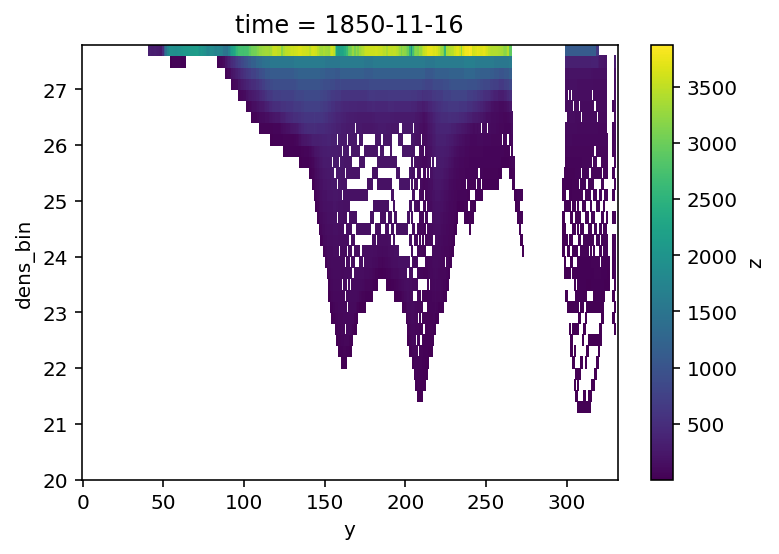

In [45]:
# plot the same slice in density coordinates
ds_rebinned.z.isel(**roi).plot(x='y')

## convert to different depth coordinates
This methodology is not limited to potential density. We can use any data_variables and  coordinates (as long as they have the corresponding dimension).

Lets try to regrid to some weird irregular depth spacing

In [46]:
# define new depth bins
bins = np.array([0, 100, 110, 120, 1000, 1030, 3000, 5000])
ds_depth = ds.drop('z')
ds_rebinned_z = vertical_rebin_wrapper(ds_depth,
                                     'olevel', # note that this is a 1D dimension, which gets seamlessy broadcasted
                                     bins,
                                     dz_name='thkcello',
                                     vert_dim='olevel')

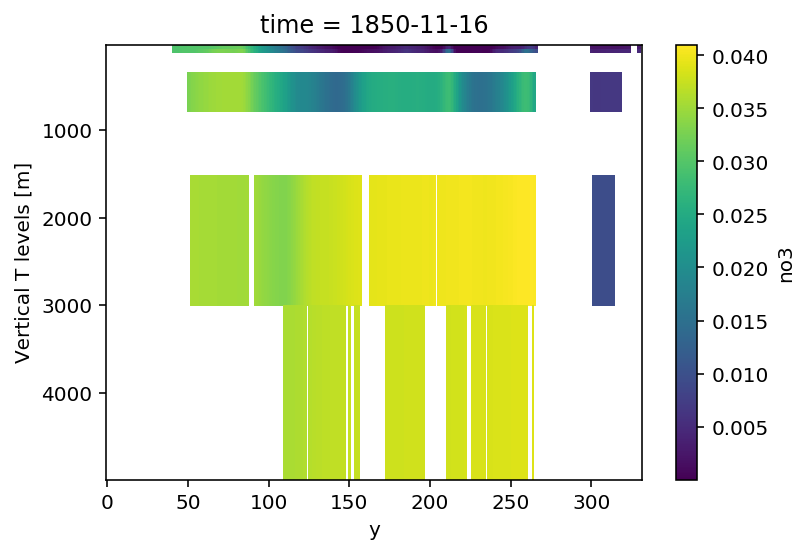

In [48]:
# plot the same slice in new coordinates
ds_rebinned_z.no3.isel(**roi).plot(x='y', yincrease=False)

That looks weird alright, but it works. A big problem of this method is that some bins are not filled. To achieve continous conservative remapping we need to implement more advanced [methods](https://discourse.pangeo.io/t/plotting-ocean-variables-in-density-coordinates-using-xhistogram/125/7?u=jbusecke)